### Keras FCN with reduced data

In [115]:
import bcolz
import numpy as np
import pandas as pd
import pickle 
from pathlib import Path
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
layers = keras.layers
from keras import metrics
import clr_callback
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.log_device_placement=True
sess = tf.Session(config=config)
keras.backend.set_session(sess)
import matplotlib.pyplot as plt
from datetime import *

In [14]:
model_path = Path('/home/ubuntu/WesternPower-Smartmeter/models/')
model_path.mkdir(exist_ok=True)

In [15]:
#load the column value dictionary
with open("data/cat_map.pkl", "rb") as dictionary_file:
       cat_map = pickle.load(dictionary_file)

In [16]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [90]:
label_col = 'energy(kWh/hh)'
categorical_cols = ['LCLid', 'stdorToU', 'Acorn_grouped', 'Acorn', 'summary', 'h_summary', 'icon', 'h_icon', 'h_precipType']
numeric_cols = ['ts_int', 'h_visibility','h_windBearing','h_temperature','h_dewPoint','h_pressure','h_apparentTemperature'
,'h_windSpeed','h_humidity','month_x','dayofweek','isHoliday','halfhourofday','temperatureMax'
,'windBearing','dewPoint','cloudCover','windSpeed','pressure','apparentTemperatureHigh','visibility','humidity','apparentTemperatureLow'
,'apparentTemperatureMax','uvIndex','temperatureLow','temperatureMin','temperatureHigh','apparentTemperatureMin'
,'moonPhase','temperatureMinTime_mod','temperatureMaxTime_mod','apparentTemperatureMinTime_mod','apparentTemperatureMaxTime_mod'
,'temperatureHighTime_mod','temperatureLowTime_mod','apparentTemperatureHighTime_mod','apparentTemperatureLowTime_mod'
,'sunsetTime_mod','sunriseTime_mod','uvIndexTime_mod']
allcols = np.concatenate([categorical_cols ,  numeric_cols ]).tolist()
allcols.append(label_col)

use_cat_cols = ['LCLid','halfhourofday', 'month_x', 'isHoliday', 'dayofweek']
use_cat_cols_vocab=[len(cat_map['LCLid']),48,12,2,7]
use_numeric_cols = ['h_temperature', 'h_humidity', 'h_windSpeed', 'moonPhase', 'uvIndex', 'visibility','humidity' ]
use_cat_cols = [allcols.index(l) for l in use_cat_cols ]
use_numeric_cols = [allcols.index(l) for l in use_numeric_cols ]
use_label_col = allcols.index(label_col) 

In [91]:
class BcolzDataGenerator(keras.utils.Sequence):
    def __init__(self, bcolz_directory, batch_size, start_indx, end_indx):
        'Initialization'
        self.da = bcolz.open(rootdir=bcolz_directory, mode='r') 
        self.batch_size = batch_size
        self.start_indx = start_indx
        self.end_indx = end_indx
        self.on_epoch_end()
    def __len__(self):
        'Denotes the number of batches per epoch'                  
        return int(np.floor((self.end_indx  - self.start_indx) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        end = self.current_indx+self.batch_size
        X = X=np.nan_to_num(self.da[self.current_indx:end])    
        
        Y = X[:,use_label_col] # The Label is the last column
        out =[]
        for cat_col_indx in use_cat_cols:
            out.append(X[:,cat_col_indx].astype('int32'))
        out.append(X[:,use_numeric_cols])
        self.current_indx = end
        return out, Y 

    def on_epoch_end(self):
        self.current_indx = self.start_indx

In [96]:
def get_fcn_model(learning_rate):
    numeric_input = layers.Input(shape=(len(use_numeric_cols),), dtype='float32', name='Numeric_input')
    embedding_model_inputs = []
    for i in range(len(use_cat_cols)):
        embedding_model_inputs.append(layers.Input(shape=(1,), dtype='int32', name="inp_"+str(i)))
    embedding_layers=[]
    for i in range(len(use_cat_cols)):
        embedding_layers.append(layers.Embedding(use_cat_cols_vocab[i], 80,  input_length=1, trainable=True) (embedding_model_inputs[i]))
    merged_e = layers.concatenate(embedding_layers, axis=-1)
    merged_e = layers.Flatten()(merged_e)
    x= layers.concatenate([merged_e, numeric_input], axis=-1)
    for i in range(7):    
        x = layers.Dense(64, activation='relu')(x)
    main_output = layers.Dense(1, activation='linear', name='main_output')(x)
    embedding_model_inputs.append(numeric_input)
    fcn_model = keras.Model(inputs=embedding_model_inputs, outputs=main_output)
    adm = keras.optimizers.Adam(lr=learning_rate)
    fcn_model.compile(optimizer=adm, loss='mse') # , metrics=[ metrics.mean_squared_error]
    return fcn_model

In [97]:
def train_model(mod):
    sess.run(tf.global_variables_initializer())
    mod.fit_generator(TG, epochs=num_epochs, validation_data =VG,  verbose=1,   callbacks=[
                        
                        keras.callbacks.ModelCheckpoint(str(model_path/'weights2.{epoch:02d}-{val_loss:.2f}.hdf5'), 
                                                              monitor='val_loss', verbose=0, 
                                                             save_best_only=True, save_weights_only=False, 
                                                               mode='auto', period=1),
                        keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
                        ])

In [99]:
split=int(160e6)
split2=int(split+10e6)
split3=int(171e6)

batch_size = 10000
num_epochs=100
patience=25
start=1
TG = BcolzDataGenerator('data/processed_main_sorted', batch_size, 1,split )
VG = BcolzDataGenerator('data/processed_main_sorted', batch_size, split, split2 )


In [ ]:
fcn_model = get_fcn_model(0.0001)
train_model(fcn_model)

Epoch 1/100
15999/15999 [==============================] - 280s 17ms/step - loss: 0.0575 - val_loss: 0.0725
Epoch 2/100
15999/15999 [==============================] - 277s 17ms/step - loss: 0.0527 - val_loss: 0.0640
Epoch 3/100
15999/15999 [==============================] - 277s 17ms/step - loss: 0.0476 - val_loss: 0.0579
Epoch 4/100
15999/15999 [==============================] - 277s 17ms/step - loss: 0.0462 - val_loss: 0.0588
Epoch 5/100
15999/15999 [==============================] - 277s 17ms/step - loss: 0.0453 - val_loss: 0.0564
Epoch 6/100
15999/15999 [==============================] - 277s 17ms/step - loss: 0.0443 - val_loss: 0.0552
Epoch 7/100
15999/15999 [==============================] - 277s 17ms/step - loss: 0.0437 - val_loss: 0.0551
Epoch 8/100
15999/15999 [==============================] - 276s 17ms/step - loss: 0.0432 - val_loss: 0.0553
Epoch 9/100
15999/15999 [==============================] - 276s 17ms/step - loss: 0.0428 - val_loss: 0.0549
Epoch 10/100
15999/15999 [==

In [134]:
fcn_model = get_fcn_model(0.0001)
fcn_model.load_weights('models/weights2.60-0.05.hdf5')
#train_model(fcn_model)

In [135]:
fcn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_0 (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
inp_1 (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
inp_2 (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
inp_3 (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
inp_4 (Inp

In [174]:
TestG = BcolzDataGenerator('data/processed_main_sorted', batch_size, split, split2 )
preds = fcn_model.predict_generator(TestG, steps=1000)

In [175]:
da = bcolz.open(rootdir='data/processed_main_sorted', mode='r')
ts = y = da[split:split+(1000*batch_size), allcols.index('ts_int')]
y = da[split:split+(1000*batch_size),-1:]
rmse_result = rmse(preds,y)
print ("RMSE is ", rmse_result )

RMSE is  0.227357


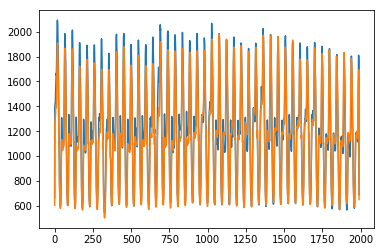

In [176]:
df = pd.DataFrame({'ts_int':ts, 'prediction':preds[:,0],'actual':y[:,0]})
df2= df.groupby(['ts_int'],as_index = False).sum()
plt.plot(df2[['actual','prediction']])
plt.show()

In [172]:
def ts_int_to_datetime(x):
    x=(x/(24*3600))
    d = np.floor(x)
    day_seconds = (x-d) *(24*3600)
    return datetime(2000,1, 1 ) + timedelta(days=d, seconds=day_seconds)

In [177]:
print (ts_int_to_datetime(ts[0]))
print (ts_int_to_datetime(ts[-1]))



2014-01-12 09:30:08
2014-02-22 20:00:00


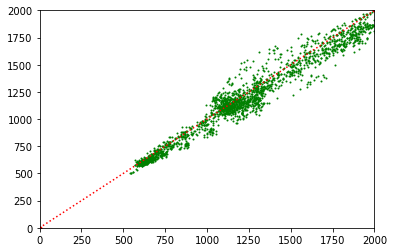

In [182]:
plt.scatter(df2['actual'].values, df2['prediction'].values, c='green', s=1)
plt.plot([0,2000],[0,2000], c= "red", marker='.', linestyle=':')
plt.axis([0,2000 , 0, 2000])
plt.show()

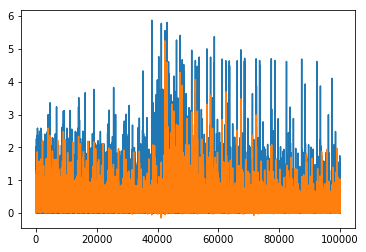

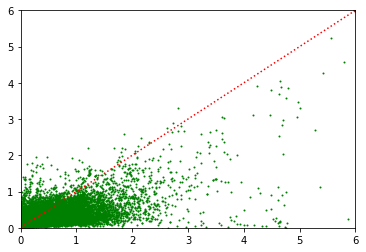

In [111]:
plt.plot(y[:100000])
plt.plot(preds[:100000])
plt.show()

plt.scatter(y[:100000], preds[:100000], c='green', s=1)
plt.plot([0,6],[0,6], c= "red", marker='.', linestyle=':')
plt.axis([0,6 , 0, 6])
plt.show()


In [109]:
rmse(preds,y)

0.22104773